# IA – Projeto 02
## Clustering – Perfis de Desempenho em corridas de F1

**Unidade Curricular:** Inteligência Artificial  
**Ano Letivo:** 2025/2026  

### Discentes

- Carlos Sousa (24880)  
- Pedro Gonçalves (26018)  
- Carlos Moreda (26875)  

---

## 1. Introdução e Objetivo

Neste Notebook 2 – Clustering vamos usar também os dados de resultados de Fórmula 1 utilizando o dataset **"Formula 1 Race Data (1950–2017)"** do Kaggle, mas agora com uma perspetiva **não supervisionada**.

Dataset original: **[Formula 1 Race Data (Kaggle)](https://www.kaggle.com/datasets/cjgdev/formula-1-race-data-19502017)**

Em vez de tentar prever diretamente se um piloto termina no pódio, o objetivo aqui é:

>Identificar grupos de perfis de desempenho em corrida de pilotos, com base em variáveis numéricas relacionadas com grelha de partida, posição final, pontos, voltas e tempos.

A ideia é descobrir automaticamente padrões como, por exemplo:

- Corridas **“dominantes”** – partir à frente e terminar à frente, com muitos pontos;
- Corridas **“de recuperação”** – partir de trás e ganhar muitas posições;
- Corridas **“anónimas”** – meio da tabela, poucos pontos;

Ou seja, cada linha continua a ser um resultado de piloto numa corrida, mas agora queremos agrupar esses resultados em tipos de corrida com comportamento semelhante.

Posto isto neste notebook vamos:

1. Definir o objetivo de negócio;  
2. Preparar os dados para clustering (seleção de variáveis, tratamento de faltas, normalização);  
3. Aplicar o algoritmo **K-Means** para diferentes valores de k;  
4. Otimizar o número de clusters (análise de **elbow** e **silhouette**);  
5. Analisar as características de cada cluster, incluindo:
   - número de elementos por cluster;
   - média, desvio padrão, mínimo e máximo das variáveis numéricas;
   - distribuição de alguns atributos categóricos (equipa, país do circuito, pódio / não pódio).

---


#### Imports e Configuração Inicial

In [244]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

sns.set(style="whitegrid")
%matplotlib inline


#### Carregamento dos datasets de F1

In [245]:
# Carregar ficheiro de resultados
results = pd.read_csv("results.csv")

# Carregar ficheiros de contexto
races = pd.read_csv("races.csv")                                   # informação da corrida (ano, circuito, data,etc)
drivers = pd.read_csv("drivers.csv", encoding="latin1")            # info dos pilotos
constructors = pd.read_csv("constructors.csv", encoding="latin1")  # info das equipas
circuits = pd.read_csv("circuits.csv", encoding="latin1")          # info dos circuitos

#### Junção de Informação de Corrida e Circuito

In [246]:
# Adicionar ano, ronda e circuito
df = results.merge(
    races[["raceId", "year", "round", "circuitId"]],
    on="raceId",
    how="left"
)

# Adicionar país do circuito
df = df.merge(
    circuits[["circuitId", "country"]],
    on="circuitId",
    how="left"
)

# Ver as primeiras linhas do dataset final
df.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,year,round,circuitId,country
0,1,18,1,1,22.0,1,1.0,1,1,10.0,...,5690616.0,39.0,2.0,01:27.5,218.3,1,2008,1,1,Australia
1,2,18,2,2,3.0,5,2.0,2,2,8.0,...,5696094.0,41.0,3.0,01:27.7,217.586,1,2008,1,1,Australia
2,3,18,3,3,7.0,7,3.0,3,3,6.0,...,5698779.0,41.0,5.0,01:28.1,216.719,1,2008,1,1,Australia
3,4,18,4,4,5.0,11,4.0,4,4,5.0,...,5707797.0,58.0,7.0,01:28.6,215.464,1,2008,1,1,Australia
4,5,18,5,1,23.0,3,5.0,5,5,4.0,...,5708630.0,43.0,1.0,01:27.4,218.385,1,2008,1,1,Australia


#### Limpeza mínima e variáveis auxiliares

In [247]:
# Remover linhas sem posição final
df = df.dropna(subset=["positionOrder"])

# Garantir que a coluna positionOrder é inteira
df["positionOrder"] = df["positionOrder"].astype(int)

# Criar a variável alvo: 1 se terminou no pódio , 0 caso contrário
df["Podium"] = (df["positionOrder"] <= 3).astype(int)

# Criar variável "ganho de posições": grid - posição final
df["gained_positions"] = df["grid"] - df["positionOrder"]

# Ver as primeiras linhas do dataset final
df.head()

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,...,rank,fastestLapTime,fastestLapSpeed,statusId,year,round,circuitId,country,Podium,gained_positions
0,1,18,1,1,22.0,1,1.0,1,1,10.0,...,2.0,01:27.5,218.3,1,2008,1,1,Australia,1,0
1,2,18,2,2,3.0,5,2.0,2,2,8.0,...,3.0,01:27.7,217.586,1,2008,1,1,Australia,1,3
2,3,18,3,3,7.0,7,3.0,3,3,6.0,...,5.0,01:28.1,216.719,1,2008,1,1,Australia,1,4
3,4,18,4,4,5.0,11,4.0,4,4,5.0,...,7.0,01:28.6,215.464,1,2008,1,1,Australia,0,7
4,5,18,5,1,23.0,3,5.0,5,5,4.0,...,1.0,01:27.4,218.385,1,2008,1,1,Australia,0,-2


## 2. Seleção de Variáveis para Clustering

Como queremos agrupar perfis de desempenho em corrida, vamos focar-nos em variáveis numéricas que descrevem o que aconteceu nessa corrida para um dado piloto:

- `grid` – posição de partida na grelha;  
- `positionOrder` – posição final oficial;  
- `gained_positions` – diferença entre posição de partida e chegada (positivo = corrida de recuperação, negativo = perda de lugares);  
- `points` – pontos obtidos na corrida;  
- `laps` – nº de voltas completadas;  
- `milliseconds` – tempo total de corrida;

#### Construção do dataset de clustering

In [248]:
# Seleção das colunas necessárias para construir o perfil dos pilotos
cols_clustering = [
    "resultId",
    "raceId",
    "driverId",
    "constructorId",
    "year",
    "round",
    "circuitId",
    "country",
    "grid",
    "positionOrder",
    "gained_positions",
    "points",
    "laps",
    "milliseconds",
    "Podium"
]

df_clust = df[cols_clustering].copy()

df_clust.head()

,resultId,raceId,driverId,constructorId,year,round,circuitId,country,grid,positionOrder,gained_positions,points,laps,milliseconds,Podium
0,1,18,1,1,2008,1,1,Australia,1,1,0,10.0,58,5690616.0,1
1,2,18,2,2,2008,1,1,Australia,5,2,3,8.0,58,5696094.0,1
2,3,18,3,3,2008,1,1,Australia,7,3,4,6.0,58,5698779.0,1
3,4,18,4,4,2008,1,1,Australia,11,4,7,5.0,58,5707797.0,0
4,5,18,5,1,2008,1,1,Australia,3,5,-2,4.0,58,5708630.0,0


#### Tratamento de valores em falta

In [249]:
# Verificar valores em falta nas colunas numéricas de interesse
numeric_cols = ["grid", "positionOrder", "gained_positions", "points", "laps", "milliseconds"]
df_clust[numeric_cols].isna().sum()

grid                    0
positionOrder           0
gained_positions        0
points                  0
laps                    0
milliseconds        17774
dtype: int64

In [250]:
# Remover linhas com valores em falta nas colunas numéricas
df_clust_clean = df_clust.dropna(subset=numeric_cols).copy()

print("Linhas originais:", df_clust.shape[0])
print("Linhas após remoção de NaN nas features:", df_clust_clean.shape[0])

df_clust_clean.head()

Linhas originais: 23777
Linhas após remoção de NaN nas features: 6003


,resultId,raceId,driverId,constructorId,year,round,circuitId,country,grid,positionOrder,gained_positions,points,laps,milliseconds,Podium
0,1,18,1,1,2008,1,1,Australia,1,1,0,10.0,58,5690616.0,1
1,2,18,2,2,2008,1,1,Australia,5,2,3,8.0,58,5696094.0,1
2,3,18,3,3,2008,1,1,Australia,7,3,4,6.0,58,5698779.0,1
3,4,18,4,4,2008,1,1,Australia,11,4,7,5.0,58,5707797.0,0
4,5,18,5,1,2008,1,1,Australia,3,5,-2,4.0,58,5708630.0,0


#### Definir matriz X e normalizar

In [251]:
# Features numéricas para clustering
features = ["grid", "positionOrder", "gained_positions", "points", "laps", "milliseconds"]

X = df_clust_clean[features].copy()

# Normalizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:5]

array([[-1.14709402, -1.09741784, -0.59098475,  0.80049647, -0.22317547,
        -0.35588703],
       [-0.40189566, -0.79730398,  0.1180316 ,  0.42460421, -0.22317547,
        -0.35270511],
       [-0.02929649, -0.49719012,  0.35437038,  0.04871195, -0.22317547,
        -0.35114552],
       [ 0.71590187, -0.19707627,  1.06338673, -0.13923417, -0.22317547,
        -0.34590739],
       [-0.77449484,  0.10303759, -1.06366232, -0.3271803 , -0.22317547,
        -0.34542354]])

## 3. Escolha do Número de Clusters (K) – K-Means

Vamos aplicar o algoritmo **K-Means** para diferentes valores de K.

Para cada K vamos calcular:

- **Inertia** – Soma das distâncias ao centroide;  
- **Silhouette Score** – Mede o quão bem separados e coesos estão os clusters.

Com base nestes gráficos, vamos escolher um valor de K “razoável” e usá-lo para treinar o modelo final de K-Means.


#### Testar vários K, calcular inertia e silhouette

In [252]:
# Testar diferentes valores de K para KMeans
range_k = range(2, 9)

inertias = []
silhouette_scores = []

for k in range_k:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = kmeans.fit_predict(X_scaled)
    
    inertia = kmeans.inertia_
    inertias.append(inertia)
    
    sil_score = silhouette_score(X_scaled, labels_k)
    silhouette_scores.append(sil_score)
    
    print(f"K = {k}: inertia = {inertia:.2f}, silhouette = {sil_score:.4f}")

K = 2: inertia = 26522.19, silhouette = 0.3110
K = 3: inertia = 20100.38, silhouette = 0.3176
K = 4: inertia = 16875.17, silhouette = 0.2921
K = 5: inertia = 14498.20, silhouette = 0.2901
K = 6: inertia = 12859.01, silhouette = 0.3019
K = 7: inertia = 11543.08, silhouette = 0.2791
K = 8: inertia = 10429.03, silhouette = 0.2672


#### Gráficos Elbow e Silhouette vs K

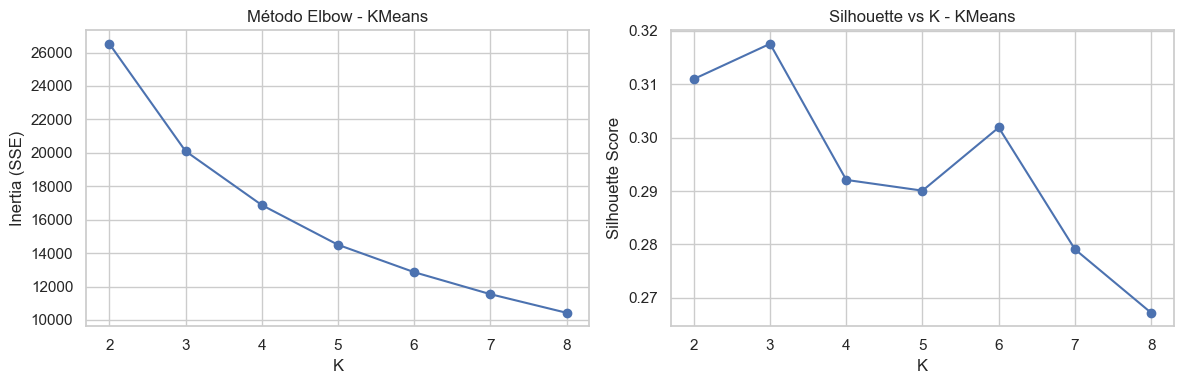

In [253]:
# Plot dos resultados
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Elbow (inertia)
ax[0].plot(list(range_k), inertias, marker="o")
ax[0].set_xlabel("K")
ax[0].set_ylabel("Inertia (SSE)")
ax[0].set_title("Método Elbow - KMeans")

# Silhouette
ax[1].plot(list(range_k), silhouette_scores, marker="o")
ax[1].set_xlabel("K")
ax[1].set_ylabel("Silhouette Score")
ax[1].set_title("Silhouette vs K - KMeans")

plt.tight_layout()
plt.show()

#### Escolher K com base na Silhouette

In [254]:
# Melhor K segundo a Silhouette
best_k_index = np.argmax(silhouette_scores)
best_k = list(range_k)[best_k_index]

print(f"Melhor K segundo a Silhouette: {best_k}")

Melhor K segundo a Silhouette: 3


#### K-Means final com K escolhido

In [255]:
# Treinar KMeans com o melhor K encontrado
k = best_k  
kmeans_final = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

sil_final = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score final (KMeans, k={k}): {sil_final:.4f}")

Silhouette Score final (KMeans, k=3): 0.3176


#### Adicionar clusters ao dataset

In [256]:
# Adicionar a coluna de cluster ao dataset
df_clusters = df_clust_clean.copy()
df_clusters["cluster"] = cluster_labels

df_clusters.head()

,resultId,raceId,driverId,constructorId,year,round,circuitId,country,grid,positionOrder,gained_positions,points,laps,milliseconds,Podium,cluster
0,1,18,1,1,2008,1,1,Australia,1,1,0,10.0,58,5690616.0,1,0
1,2,18,2,2,2008,1,1,Australia,5,2,3,8.0,58,5696094.0,1,0
2,3,18,3,3,2008,1,1,Australia,7,3,4,6.0,58,5698779.0,1,0
3,4,18,4,4,2008,1,1,Australia,11,4,7,5.0,58,5707797.0,0,2
4,5,18,5,1,2008,1,1,Australia,3,5,-2,4.0,58,5708630.0,0,0


## 4. Análise dos Clusters

Depois de atribuir um cluster a cada resultado (piloto-corrida), vamos analisar:

- Quantos registos existem em cada cluster;
- As estatísticas básicas (média, desvio padrão, mínimo, máximo) das variáveis numéricas por cluster;
- A distribuição de algumas variáveis categóricas, como:
  - pódios (`Podium`);
  - equipas (`constructorId`);
  - país do circuito (`country`).

Isto vai permitir interpretar cada cluster como um certo tipo de corrida.

#### Tamanho dos clusters

In [257]:
# Contagem de elementos por cluster
df_clusters["cluster"].value_counts().sort_index()

cluster
0    3676
1     124
2    2203
Name: count, dtype: int64

#### Estatísticas numéricas por cluster

In [258]:
# Estatísticas descritivas por cluster
cluster_stats = (
    df_clusters
    .groupby("cluster")[features]
    .agg(["mean", "std", "min", "max"])
    .round(3)
)

cluster_stats

grid                positionOrder                gained_positions  \
           mean    std min max          mean    std min max             mean   
cluster                                                                        
0         3.805  2.228   0  14         2.924  1.851   1  14            0.881   
1        15.097  9.462   1  33         6.452  3.723   1  16            8.645   
2        12.304  4.056   2  27         7.447  3.286   1  22            4.857   

                ... points           laps                   milliseconds  \
           std  ...    min   max     mean     std min  max          mean   
cluster         ...                                                        
0        2.450  ...    0.0  50.0   62.653  14.663  12  138  6.231059e+06   
1        8.332  ...    0.0   9.0  198.952  11.674  70  200  1.398057e+07   
2        4.781  ...    0.0  24.0   57.204  14.018  12  100  5.991749e+06   

                                              
                 std         min         max  
cluster                                       
0        1411069.790   1474899.0  14712762.0  
1         478766.597  12971360.0  15090540.0  
2        1148634.479   1525968.0  14743144.0  

[3 rows x 24 columns]

#### Distribuição de pódios por cluster

In [259]:
# Tabela de contingência: cluster vs Podium
podium_crosstab = pd.crosstab(df_clusters["cluster"], df_clusters["Podium"],
                              rownames=["Cluster"], colnames=["Podium"])

podium_crosstab

Podium,0,1
Cluster,,
0,1143,2533
1,91,33
2,1990,213


#### Juntar nome da equipa para análise

In [260]:
# Juntar nome da equipa para análise
df_clusters = df_clusters.merge(
    constructors[["constructorId", "name", "nationality"]],
    on="constructorId",
    how="left",
    suffixes=("", "_constructor")
)

df_clusters.rename(columns={"name": "constructor_name",
                            "nationality": "constructor_nationality"}, inplace=True)

df_clusters[["constructorId", "constructor_name", "constructor_nationality"]].head()

,constructorId,constructor_name,constructor_nationality
0,1,McLaren,British
1,2,BMW Sauber,German
2,3,Williams,British
3,4,Renault,French
4,1,McLaren,British


#### Equipas mais frequentes por cluster

In [261]:
# Top 5 equipas por cluster 
for c in sorted(df_clusters["cluster"].unique()):
    print(f"\n=== Cluster {c} ===")
    top_teams = (
        df_clusters[df_clusters["cluster"] == c]["constructor_name"]
        .value_counts()
        .head(3)
    )
    print(top_teams)



=== Cluster 0 ===
constructor_name
Ferrari     896
McLaren     580
Williams    442
Name: count, dtype: int64

=== Cluster 1 ===
constructor_name
Kurtis Kraft    72
Epperly         11
Kuzma           10
Name: count, dtype: int64

=== Cluster 2 ===
constructor_name
McLaren     222
Williams    207
Ferrari     184
Name: count, dtype: int64


#### PCA para visualização 2D dos clusters

In [262]:
# Aplicar PCA para visualização dos clusters
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

print("Variância explicada pelas 2 componentes principais:",
      pca.explained_variance_ratio_.sum())

Variância explicada pelas 2 componentes principais: 0.6718837118436526


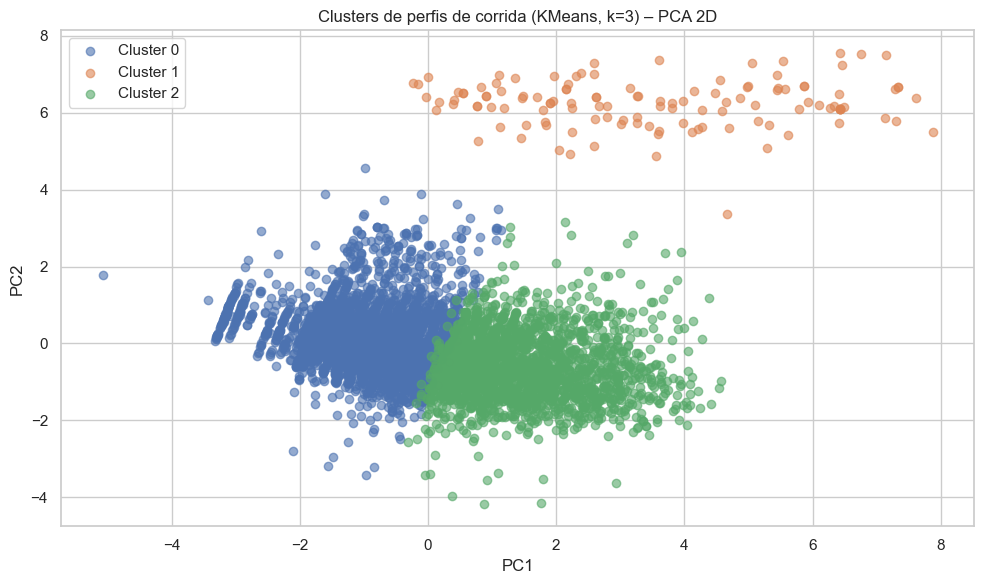

In [263]:
# Visualizar clusters
plt.figure(figsize=(10, 6))

for cluster_id in sorted(df_clusters["cluster"].unique()):
    mask = (df_clusters["cluster"] == cluster_id)
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        alpha=0.6,
        label=f"Cluster {cluster_id}"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"Clusters de perfis de corrida (KMeans, k={k}) – PCA 2D")
plt.legend()
plt.tight_layout()
plt.show()

## 5. Conclusão

### 5.1. Resultados do clustering (K-Means)

Depois de preparado o dataset, foram selecionadas 6003 corridas com informação completa para aplicar o algoritmo K-Means.

Foi testado vários valores de `k` e, de acordo com o **silhouette score**, o melhor resultado foi obtido com **k = 3**. Com este valor, os clusters ficaram distribuídos da seguinte forma:

- **Cluster 0** → 3 676 corridas (61%)  
- **Cluster 1** → 124 corridas (2%)  
- **Cluster 2** → 2 203 corridas (37%)

A projeção em 2D com PCA retém cerca de 67% da variância total, permitindo visualizar de forma razoável a separação entre os três grupos, com o cluster 0 a destacar-se claramente dos restantes.

---

### 5.2. Caracterização resumida dos clusters

De forma resumida, os clusters podem ser interpretados da seguinte forma:

- **Cluster 0 – Corridas “dominantes” / equipas de topo**  
  - `grid` e `positionOrder` médios baixos, partem à frente e terminam à frente;  
  - elevada percentagem de pódios (`Podium = 1` em muitos casos);  
  - dominado por construtores como **Ferrari, McLaren, Williams, Red Bull e Mercedes**;  
  - representa o cenário de boas performances de equipas fortes.

- **Cluster 1 – Corridas “históricas/longas” com grandes recuperações**  
  - grelhas grandes (`grid` médio elevado);  
  - grandes ganhos de posições (`gained_positions` elevado);  
  - presença de construtores clássicos como **Kurtis Kraft, Epperly, Kuzma, Watson, Phillips**, associados a corridas mais antigas e atípicas no contexto da F1;  
  - funciona praticamente como um cluster de corridas **históricas/outliers**.

- **Cluster 2 – Corridas de “recuperação / meio da tabela”**  
  - partida mais a meio/atrás na grelha (`grid` em torno de 12);  
  - recuperações moderadas (`gained_positions` em média positivo, mas menor que no cluster 1);  
  - maioria das corridas na zona de pontos, com pódios ocasionais;  
  - forte presença de equipas como **McLaren, Williams, Ferrari, Sauber e Force India**, mas com desempenhos menos dominantes do que no cluster 0.

---

### 5.3. Conclusão final

Resumindo, o clustering permitiu:

- Identificar três perfis distintos de desempenho em corrida:  
  - corridas dominantes de equipas de topo (cluster 0);  
  - corridas históricas/atípicas e muito longas, com grandes recuperações (cluster 1);  
  - corridas de recuperação e meio da tabela, com resultados mais modestos (cluster 2).
- Mostrar que é possível extrair estrutura útil dos dados de F1 apenas com variáveis numéricas de desempenho